# My own BackPropagation Implementation

## Basic definitions

In [28]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import random

#let's define some basic functions. Even though I am not using anything besides sigmoid function
#, I have defined the softmax and the derivative 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def identity(x):
    return x

def relu(x):
    return np.maximum(np.zeros(x.shape[0]),x)

def identity_derivative(x):
    return 1


def sigmoid_derivative(sigmoid_x): # we calculate the derivative based on the sigmoid function value
    return sigmoid_x*(1-sigmoid_x)

def tanh_derivative(x):
    return 1-x**2

def derivative(f):
    if f == sigmoid:
        return sigmoid_derivative
    elif f == np.tanh:
        return tanh_derivative
    elif f == identity:
        return identity_derivative
    else:
        return None

rot180 = lambda X: np.rot90(X,2)
    
def maxpool(x,pool_d):
    
    def local_max_indices(x,pool_d): #if is not devidable wihch can happen as a result of conv, we need to do something about it
        """Return maximum in groups of pool_dxpool_d for a N,h,w image"""
        N,h,w = x.shape
        x = x.reshape(N,h/pool_d,pool_d,w/pool_d,pool_d).swapaxes(2,3).reshape(N,h/pool_d,w/pool_d,pool_d*pool_d)
        return np.argmax(x,axis=3)    
    
    def global_max_indices(x,pool_d):
        N = x.shape[0]
        image_d= x.shape[1]
        ip_ratio = image_d / pool_d
        lmi = local_max_indices(x,pool_d)
        max_local_x,max_local_y = np.unravel_index(lmi.flat,dims=(pool_d,pool_d))
        max_y =  max_local_y + np.tile(np.tile(range(ip_ratio),ip_ratio)*pool_d,N)
        max_x =  max_local_x + np.tile(np.repeat(np.arange(ip_ratio), ip_ratio)*pool_d,N)
        Ns = np.repeat(np.arange(N),ip_ratio**2)
        return np.vstack([Ns,max_x,max_y]).T    
    
    N= x.shape[0]
    image_d = x.shape[1]
    crop_length = image_d%pool_d
    x = x[:,:image_d-crop_length,:image_d-crop_length]
    gmi = global_max_indices(x,pool_d)
    maxes =  x[gmi[:,0],gmi[:,1],gmi[:,2]].reshape(N,image_d/pool_d,image_d/pool_d)
    return gmi,maxes

def up_sample(gmi,values,image_d,pool_d):
    N =values.shape[0] 
    out = np.zeros([N,image_d,image_d])
    out[gmi[:,0],gmi[:,1],gmi[:,2]] = 1 #maxes are equal to one
    val_repeated = np.repeat(np.repeat(values,pool_d,axis=1),pool_d,axis=2)
    crop_length = image_d - val_repeated.shape[1]
    val_repeated = np.pad(val_repeated, ((0,0),(0,crop_length), (0,crop_length)), mode='constant', constant_values=0) # pad with zero to reverse cropping 
    return out * val_repeated

# Loading Data

In [172]:
import pandas as pd

train_images = pd.read_csv("./train.csv")
#train_images = train_images[:10000]
# test_images = pd.read_csv("./test.csv")
#train_images = train_images.loc[1:1000]

train_images_numpy = train_images[train_images.columns[1:]].as_matrix().astype(float)
from sklearn.preprocessing import scale,LabelBinarizer
train_scaled  = scale(train_images_numpy)

X = train_scaled.reshape(-1,28,28)# making the images square before feeding it to the CNN
lb = LabelBinarizer()
Y= lb.fit_transform(train_images['label'])

# My backpropagation for CNN training

In [169]:
from math import sqrt
import numpy as np
import random
from scipy.signal import convolve2d

class bornaCNN:
    def __init__(self, mlp_layers_sizes, mlp_activations, CNN_activations,input_dimension ,num_of_kernels=5
                 ,kernels_dimensions=[5], max_pool_dimensions = [2] , eta=0.05, epocs=5, update='online', verbose=True):
        
        self.errors=[]
        self.eta=eta

        self.epocs=epocs
        self.num_of_kernels = num_of_kernels        
        self.kernels_dimensions = kernels_dimensions
        self.mlp_activations,self.CNN_activations = mlp_activations,CNN_activations
        self.max_pool_dimensions = max_pool_dimensions
        ######## mlp_layers_sizes doesn't contain the the number of nodes between the last maxp
        # we calculate this->
        
        lcmld = input_dimension # lcmd = Last Conv-Max Layer Dimension
        for i in range(len(kernels_dimensions)):
            lcmld = lcmld - kernels_dimensions[i]+1
            lcmld = lcmld / max_pool_dimensions[i]

        self.mlp_layers_sizes = np.insert(mlp_layers_sizes,0,num_of_kernels*lcmld*lcmld) # does not contain the 
        #####################
        self.num_mlp_layers = len(self.mlp_layers_sizes )
        self.verbose= verbose
        self.kernels_W , self.kernels_B = self.generate_random_kernels()
        #self.mlp_W , self.mlp_B= self.generate_random_mlp_weights()
        self.num_of_kernels = num_of_kernels
    
    
    def generate_random_kernels(self):#for now, we just use the same initialization technic that we use for MLP weights
        kernels_W={}
        kernels_B={}
        for i,kd in enumerate(self.kernels_dimensions):# number of Convolutions layers
            i = 2*i
            #upper = 4*sqrt(6)/sqrt(self.layers_sizes[i]+self.layers_sizes[i+1])
            upper = 4*sqrt(6)/sqrt(kd**2+1)
            key = str(i)+'-'+str(i+1)
            kernels_B[key] = np.zeros(self.num_of_kernels)
            #kernels_W[key] = np.random.uniform(-upper,upper,[self.num_of_kernels,kd,kd])
            kernels_W[key] = np.random.uniform(-3.,3.,[self.num_of_kernels,kd,kd])
        return kernels_W,kernels_B
        
    def generate_random_mlp_weights(self):
        mlp_W={}
        mlp_B={}
        for i in range(len(self.mlp_layers_sizes)-1):
            upper = 4*sqrt(6)/sqrt(self.mlp_layers_sizes[i]+self.mlp_layers_sizes[i+1])
            #weight also includes biases
            mlp_B[str(i)+"-"+str(i+1)] = np.zeros(self.mlp_layers_sizes[i+1])
            mlp_W[str(i)+"-"+str(i+1)] = np.random.uniform(-upper,upper, self.mlp_layers_sizes[i:i+2])#np.ones( self.layers_sizes[i:i+2])
        return mlp_W,mlp_B
    
    def _calc_error(self,X,Y):
        prediction = np.zeros(Y.shape)
        for i in range(X.shape[0]):
            ffr_K,gmi,ffr_mlp = self.feed_forward(X[i])
            prediction[i] = ffr_mlp[-1]
        error = .5*np.sum((Y-prediction)**2)/(X.shape[0])
        print "Error->",error
        return error
        
    def fit(self,X,Y):
        self.errors=[]
        self.mlp_W , self.mlp_B= self.generate_random_mlp_weights()
        self.errors.append(self._calc_error(X,Y))# Error before we start training        
        for i in range(self.epocs):
            if self.verbose:
                if i<10:
                    print ("epoc->",i+1)
                elif i<100 and i%10==0:
                    print ("epoc->",i)
                elif i<1000 and i%100==0:
                    print ("epoc->",i)
                elif i<10000 and i%1000==0:
                    print ("epoc->",i)
                elif i<100000 and i%10000==0:
                    print ("epoc->",i)
            
            for j in range(X.shape[0]):
                inputx = X[j,:,:]
                target = Y[j,:]
                ffr_K,all_gmi,ffr_mlp = self.feed_forward(inputx)
                
                first_delta, delta_MLP_W, delta_MLP_B = self.calc_weight_updates_MLP(ffr_mlp,target)
                self.update_weights(delta_MLP_W, delta_MLP_B,"mlp")
                
                delta_K_W, delta_K_B =              self.calc_weight_updates_K(ffr_K , all_gmi , first_delta)
                self.update_weights(delta_K_W, delta_K_B,"kernel")
                
                
                
            self.errors.append(self._calc_error(X,Y))
                
    def update_weights(self,delta_W,delta_B,layer_type):
        
        if layer_type.lower() == 'mlp':
            for i in range(self.num_mlp_layers-1): #going through layers
                index=str(i)+"-"+str(i+1)
                self.mlp_W[index] -= self.eta * delta_W[index]
                self.mlp_B[index] -= self.eta * delta_B[index]
        else: #conv
            for key in delta_W:
                self.kernels_W[key] -= self.eta * delta_W[key]
                self.kernels_B[key] -= self.eta * delta_B[key]

#     def predict(self,X):
#         nn_output = self.feed_forward(X)
#         labels = np.argmax(nn_output[-1],axis=1)
#         return labels
    
    def calc_weight_updates_MLP(self,ffr_mlp,target):
        # https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/        
        #step1: output layer
        delta_W={}
        delta_B={}
        
        this_output = ffr_mlp[-1]
        previous_output = ffr_mlp[-2]

        act_deriv = derivative(self.mlp_activations[self.num_mlp_layers-2])
        this_delta = ((this_output - target)) * act_deriv(this_output) 

        weight_chagnge = np.outer(previous_output , this_delta)
        
        delta_W[str(self.num_mlp_layers-2)+"-"+str(self.num_mlp_layers-1)] = weight_chagnge
        delta_B[str(self.num_mlp_layers-2)+"-"+str(self.num_mlp_layers-1)] = this_delta
        
        #step2: Hidden Layers
        for i in reversed(range(0,self.num_mlp_layers-1)): # Going through all the layers backwards* changed range(1 to range(0
            next_layer_delta = this_delta
            hl_out_weights = self.mlp_W[str(i)+"-"+str(i+1)]            
            
            if i>0:
                hl_input = ffr_mlp[i-1]
                hl_output = ffr_mlp[i]
                act_deriv = derivative(self.mlp_activations[i-1])
                this_delta = np.dot(hl_out_weights, next_layer_delta) * act_deriv(hl_output)
                weight_chagnge = np.outer(hl_input,this_delta)
                delta_W[str(i-1)+"-"+str(i)] =  weight_chagnge     
                delta_B[str(i-1)+"-"+str(i)] =  this_delta
            else:#i ==0 input layer's output is f(x)=x
                hl_out_weights = self.mlp_W[str(i)+"-"+str(i+1)]
                first_delta = np.dot(hl_out_weights, next_layer_delta) # this part is equal to 1* act_deriv(hl_output)
            
        return first_delta, delta_W, delta_B
    
    def feed_forward(self,x): #feed forward, x is a 2d image matrix
        x = np.array(x)        
        ffr_K = []
        all_gmi=[]
        layer_input = np.repeat(x[np.newaxis],self.num_of_kernels,axis=0)# make 2d inpu to k, 2d inpus
        ffr_K.append(layer_input)
        
        for i,kd in enumerate(self.kernels_dimensions): #going through each Con layer and the max pool layer
            
            # We do apply the kernels first
            conv_layer_output = np.zeros([self.num_of_kernels,layer_input.shape[1]-kd+1,layer_input.shape[1]-kd+1],dtype=float) # conv_output empty
            key = str(2*i)+'-'+str(2*i+1)
            Ks,Bs = self.kernels_W[key] , self.kernels_B[key]
            for j in range(Ks.shape[0]):#iterating through the each kernel
                conv_layer_output[j] = convolve2d(layer_input[j],Ks[j],'valid') + Bs[j]
            conv_layer_output = self.CNN_activations[i](conv_layer_output) #applying the activation function
            ffr_K.append(conv_layer_output) #append the convolution
            ## Max pool dimension
            maxp_d = self.max_pool_dimensions[i]
            gmi, maxp_output = maxpool(conv_layer_output,maxp_d)
            all_gmi.append(gmi)
            ffr_K.append(maxp_output)
            layer_input = maxp_output # for the next iteration

        # before passing on the last layer to the fully connect network, we need to flatten it: layer_input.reshape(-1)
        #layer_input is actually the output of last layer before MLP
        
        x = layer_input.reshape(-1)#flatten the 2d maxpool output
        ffr_mlp=[x]#Feed Forward Result
        for i in range(self.num_mlp_layers-1):
            W = self.mlp_W[str(i)+"-"+str(i+1)]
            B = self.mlp_B[str(i)+"-"+str(i+1)]
            y = self.mlp_activations[i](np.dot(x,W) + B) #clculate the output of the layer
            x=y
            ffr_mlp.append(y)
        return ffr_K,all_gmi,ffr_mlp
    
    def calc_weight_updates_K(self,ffr_K,gmi,first_delta):
        detla_k_W={}
        detla_k_B={}
        delta_dim = int(sqrt(first_delta.shape[0] / self.num_of_kernels))
       
        maxpool_delta = first_delta.reshape(self.num_of_kernels,delta_dim,delta_dim)
        
        for i in reversed(range(len(self.kernels_dimensions))):
            cnn_derivative = derivative(self.CNN_activations[i])
            #first the maxpool
            image_d = ffr_K[i+1].shape[1]
            conv_delta = up_sample(gmi[i],maxpool_delta ,image_d, self.max_pool_dimensions[i])
            conv_delta = conv_delta*cnn_derivative(ffr_K[2*i+1])

            #conv layer delta
            key = str(2*i)+'-'+str(2*i+1)
            
            detla_k_W[key] = np.zeros(self.kernels_W[key].shape) 
            detla_k_B[key] = np.zeros(self.kernels_B[key].shape) 
            for j in range(self.num_of_kernels):
                this_k = self.kernels_W[key][j]
                detla_k_W[key][j] = rot180(convolve2d(ffr_K[2*i][j],rot180(conv_delta[j]),"valid")) 
                detla_k_B[key][j] = np.sum(conv_delta[j])
                
        return detla_k_W,detla_k_B


Error-> 1.31568934027
('epoc->', 1)
Error-> 0.0630383170412
('epoc->', 2)
Error-> 0.046176861601
('epoc->', 3)
Error-> 0.0342127962648
('epoc->', 4)
Error-> 0.0293736574007
('epoc->', 5)
Error-> 0.0274794815292


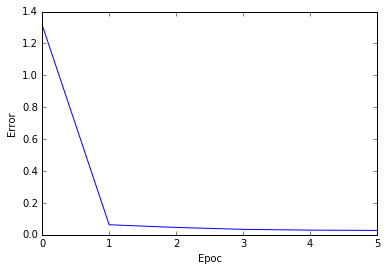

In [173]:
np.random.seed(0)
bornacnn = bornaCNN(mlp_layers_sizes=[20,10], 
                    mlp_activations=[sigmoid,sigmoid,sigmoid,sigmoid,sigmoid], 
                    CNN_activations = [sigmoid,sigmoid],input_dimension = 28 ,
                    num_of_kernels=5,kernels_dimensions=[5], max_pool_dimensions = [2],
                    epocs=5, eta = 0.15)
bornacnn.fit(X,Y)# Fit does not train the Kernels yet. This is the next step. 
%matplotlib inline  
plt.plot(range(len(bornacnn.errors)),bornacnn.errors)
plt.xlabel('Epoc')
plt.ylabel('Error')
plt.show()